In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
import numpy as np


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
from avgn.utils.paths import DATA_DIR
from avgn.magenta.nsynthreader import NSynthDataset

In [6]:
training_tfrecords = list((DATA_DIR / "tensorflow_datasets"/"nsynth").glob('**/*train.tfrecord*'))

In [43]:
if int(tf.__version__[0]) < 2:
    from tensorflow import FixedLenFeature, parse_single_example
else:
    from tensorflow.io import FixedLenFeature, parse_single_example


# https://github.com/keithito/tacotron/blob/master/util/audio.py
def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)

def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)


def tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _amp_to_db_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals, hparams.win_length, hparams.hop_length, hparams.n_fft, pad_end=True
    )


class NSynthDataset(object):
    def __init__(self, tf_records, hparams, is_training=True):
        self.is_training = is_training
        self.hparams = hparams
        # create dataset of tfrecords
        self.raw_dataset = tf.data.TFRecordDataset(tf_records)
        # prepare dataset iterations
        self.dataset = self.raw_dataset.map(lambda x: self._parse_function(x))
        self.dataset_batch = self.dataset.shuffle(1000)
        self.dataset_batch = self.dataset.batch(hparams.batch_size)
        
    def print_feature_list(self):
        # get the features
        element = list(self.raw_dataset.take(count=1))[0]
        # parse the element in to the example message
        example = tf.train.Example()
        example.ParseFromString(element.numpy())
        print(list(example.features.feature))


    def _parse_function(self, example_proto):
        features = {
            "id": FixedLenFeature([], dtype=tf.string),
            "pitch": FixedLenFeature([1], dtype=tf.int64),
            "velocity": FixedLenFeature([1], dtype=tf.int64),
            "audio": FixedLenFeature([64000], dtype=tf.float32),
            # "qualities": FixedLenFeature([10], dtype=tf.int64),
            "instrument/source": FixedLenFeature([1], dtype=tf.int64),
            "instrument/family": FixedLenFeature([1], dtype=tf.int64),
            "instrument/label": FixedLenFeature([1], dtype=tf.int64),
        }
        example = parse_single_example(example_proto, features)
        return example

In [44]:
class HParams(object):
    """ Hparams was removed from tf 2.0 so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
hparams = HParams(  
    batch_size = 32,
    win_length = 1024,
    n_fft = 1024,
    hop_length=32,
    ref_level_db = 20,
    min_level_db = -100,
    power = 1, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
)

In [45]:
dset = NSynthDataset([str(i) for i in training_tfrecords], hparams)

In [46]:
dset.print_feature_list()

['qualities/percussive', 'qualities/dark', 'instrument/family', 'qualities/fast_decay', 'qualities/distortion', 'instrument/label', 'velocity', 'qualities/long_release', 'qualities/multiphonic', 'instrument/source', 'qualities/nonlinear_env', 'pitch', 'qualities/tempo-synced', 'qualities/reverb', 'qualities/bright', 'id', 'audio']


In [47]:
exs = iter(dset.dataset_batch)

In [48]:
for i in range(2):
    ex = next(exs)
    print(ex['audio'].shape)

(32, 64000)
(32, 64000)


In [49]:
ex = next(iter(dset.dataset))

In [50]:
ex

{'audio': <tf.Tensor: id=688, shape=(64000,), dtype=float32, numpy=
 array([ 3.0186407e-06, -3.1179025e-06,  3.0848969e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>,
 'id': <tf.Tensor: id=689, shape=(), dtype=string, numpy=b'organ_electronic_046-056-025'>,
 'instrument/family': <tf.Tensor: id=690, shape=(1,), dtype=int64, numpy=array([6])>,
 'instrument/label': <tf.Tensor: id=691, shape=(1,), dtype=int64, numpy=array([701])>,
 'instrument/source': <tf.Tensor: id=692, shape=(1,), dtype=int64, numpy=array([1])>,
 'pitch': <tf.Tensor: id=693, shape=(1,), dtype=int64, numpy=array([56])>,
 'velocity': <tf.Tensor: id=694, shape=(1,), dtype=int64, numpy=array([25])>}

In [24]:
def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals, hparams.win_length, hparams.hop_length, hparams.n_fft, pad_end=False
    )

In [52]:
test = _stft_tensorflow(ex['audio'], hparams)

In [53]:
test.shape

TensorShape([2000, 513])

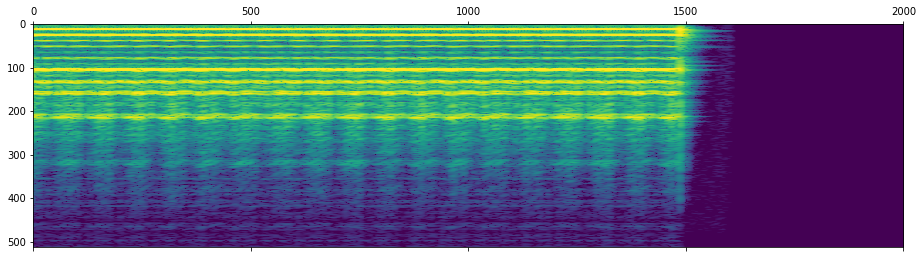

In [54]:
spec = spectrogram_tensorflow(ex['audio'], hparams)
plt.matshow((spec.numpy()).T)

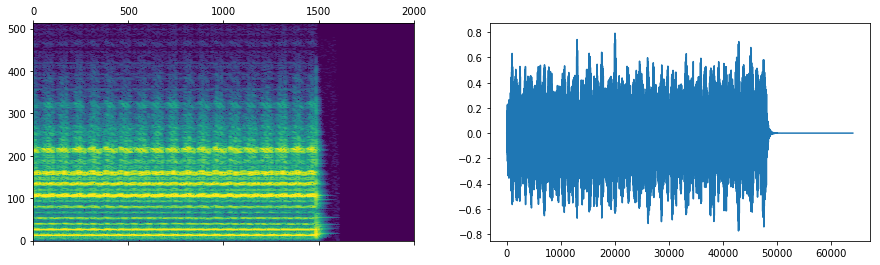

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
axs[0].matshow(spec.numpy().T, aspect='auto', origin='lower')
axs[1].plot(ex['audio'].numpy())
IPython.display.Audio(data=ex['audio'].numpy(), rate=16000)

In [56]:
import librosa 

def _stft(y, hparams):
  return librosa.stft(y=y, n_fft=hparams.n_fft, hop_length=hparams.hop_length, win_length=hparams.win_length)


def _istft(y, hparams):
  return librosa.istft(y, hop_length=hparams.hop_length, win_length=hparams.win_length)

def _griffin_lim(S, hparams):
  '''librosa implementation of Griffin-Lim
  Based on https://github.com/librosa/librosa/issues/434
  '''
  angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
  S_complex = np.abs(S).astype(np.complex)
  y = _istft(S_complex * angles, hparams)
  for i in range(hparams.griffin_lim_iters):
    angles = np.exp(1j * np.angle(_stft(y, hparams)))
    y = _istft(S_complex * angles, hparams)
  return y

def _db_to_amp(x):
  return np.power(10.0, x * 0.05)

def _denormalize(S, hparams):
  return (np.clip(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db

def inv_spectrogram(spectrogram, hparams):
  '''Converts spectrogram to waveform using librosa'''
  S = _db_to_amp(_denormalize(spectrogram, hparams) + hparams.ref_level_db)  # Convert back to linear
  return _griffin_lim(S ** hparams.power, hparams)          # Reconstruct phase

In [57]:
hparams.__dict__

{'batch_size': 32,
 'win_length': 1024,
 'n_fft': 1024,
 'hop_length': 32,
 'ref_level_db': 20,
 'min_level_db': -100,
 'power': 1,
 'griffin_lim_iters': 50,
 'pad': True}

In [58]:
reconstructed_y = inv_spectrogram(spec.numpy().T, hparams)

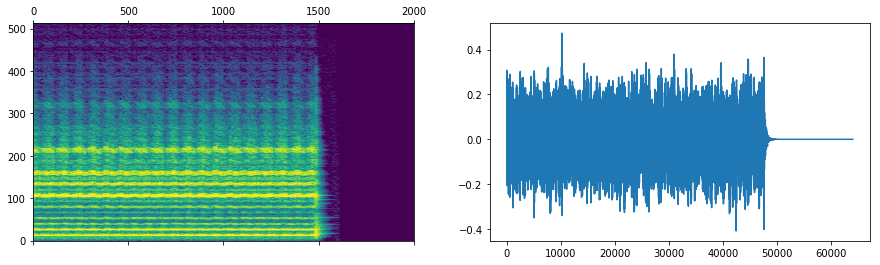

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
axs[0].matshow(spec.numpy().T, aspect='auto', origin='lower')
axs[1].plot(reconstructed_y)
IPython.display.Audio(data=reconstructed_y, rate=16000)

In [81]:
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64,
    num_spectrogram_bins=513,
    sample_rate=8000,
    lower_edge_hertz=125.0,
    upper_edge_hertz=3800.0,
    dtype=tf.dtypes.float32,
    name=None,
)

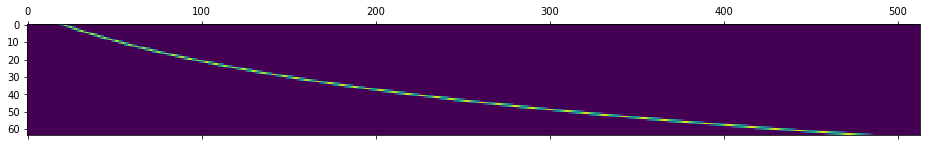

In [82]:
plt.matshow(mel_matrix.numpy().T)

In [83]:
M = tf.tensordot(spec,mel_matrix, 1)

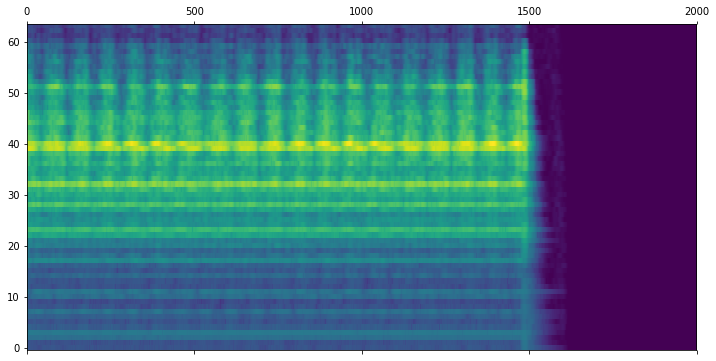

In [84]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
ax.matshow(M.numpy().T, aspect='auto', origin='lower')

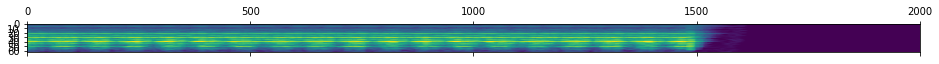

In [85]:
plt.matshow(M.numpy().T)

In [86]:
MFCC = tf.signal.mfccs_from_log_mel_spectrograms(M)

In [91]:
MFCC.shape

TensorShape([2000, 64])

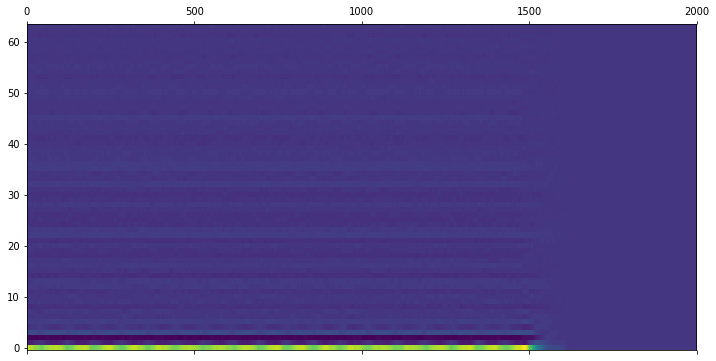

In [90]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
ax.matshow(MFCC.numpy().T, aspect='auto', origin='lower')